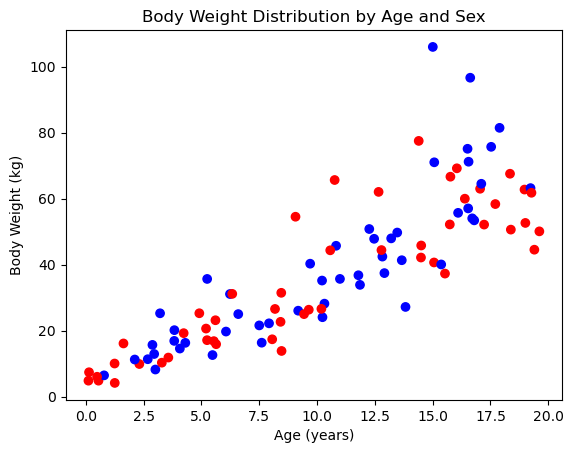

In [8]:
# Dataset generation: 2-CMT model with i.v. bolus dosing (Robbie PK model)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numpy.random import default_rng

# Set a seed for reproducible results
rng = default_rng(seed=1)

def sumpter(age, sex="m", iiv=True):
    FFEM_WTMAX = np.where(sex == "m", 1, 0.884)

    age_weeks = age * 52.18  # Convert years to weeks

    n = len(age)

    pma = age_weeks + 40  # Postmenstrual age in weeks

    # Parameters from Sumpter & Holford Pediatr Anesth. 2011
    WT_max1 = 2.76  # kg
    TM50_WT1 = 38.5  # weeks
    Hill1_WT1 = 12.9
    Hill2_WT1 = 2.74
    WT_max2 = 16.4  # kg
    TM50_WT2 = 2.10 * 52.18  # weeks
    Hill1_WT2 = 2.04
    Hill2_WT2 = 1
    WT_max3 = 40.2  # kg
    TM50_WT3 = 12.4 * 52.18  # weeks
    Hill1_WT3 = 2.87
    Hill2_WT3 = 0
    TLAG_WT4 = TM50_WT3
    WT_max4 = 33.6  # kg
    THALF_WT4 = 3.61 * 52.18  # weeks
    THALF_PPV_AGE = 3.52 * 52.18  # years to weeks

    RUV_CV = 0.074

    # Jointly simulate IIV parameters
    etas = np.zeros((n, 5))
    if iiv:
        corrmat = np.array([[1, 0.753, 0, 0, -0.698],
                            [0.753, 1, 0, 0, -0.957],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 1, 0],
                            [-0.698, -0.957, 0, 0, 1]])
        ppv_sd = np.array([0.531, 0.388, 0.466, 0.245, 0.0572])
        cov_matrix = np.diag(ppv_sd) @ corrmat @ np.diag(ppv_sd)
        etas = rng.multivariate_normal(mean=np.zeros(5), cov=cov_matrix, size=n)

    # Maturation process calculations
    WT1 = (1 / (1 + (TM50_WT1 / pma) ** (np.where(pma < TM50_WT1, Hill1_WT1, Hill2_WT1)))) * FFEM_WTMAX * WT_max1
    WT2 = (1 / (1 + (TM50_WT2 / pma) ** (np.where(pma < TM50_WT2, Hill1_WT2, Hill2_WT2)))) * WT_max2
    WT3 = (1 / (1 + (TM50_WT3 / pma) ** (np.where(pma < TM50_WT3, Hill1_WT3, Hill2_WT3)))) * WT_max3
    WT4 = np.where(pma < TLAG_WT4, 0, FFEM_WTMAX * WT_max4 * (1 - np.exp(-np.log(2) / THALF_WT4 * (pma - TLAG_WT4))))

    if iiv:
        WT1 *= np.exp(etas[:, 0])
        WT2 *= np.exp(etas[:, 1])
        WT3 *= np.exp(etas[:, 2])
        WT4 *= np.exp(etas[:, 3])

    BW = WT1 + WT2 + WT3 + WT4
    if iiv:
        IIV_ = np.exp(-np.log(2) / THALF_PPV_AGE * pma)
        BW *= np.exp(etas[:, 4] * IIV_)
        BW *= (1 + rng.normal(0, RUV_CV, len(BW)))  # Residual variability

    return BW

# Number of individuals (IDs)
N = 100

# Covariate distribution
sex = np.array(['m', 'f'] * (N // 2))
age = rng.uniform(0, 20, N)
BW = sumpter(age=age, sex=sex)

# Plotting the covariate distribution
plt.scatter(age, BW, c=['blue' if s == 'm' else 'red' for s in sex])
plt.xlabel('Age (years)')
plt.ylabel('Body Weight (kg)')
plt.title('Body Weight Distribution by Age and Sex')
plt.show()


In [ ]:
# Dosing scheme: monthly body weight-normalized i.v. bolus doses
reldose = 15  # [mg/kg]
ndosing = 5
interval = 30  # [days]
D = [BW[i] * reldose * np.ones(ndosing) for i in range(N)]  # [mg]
tD = np.arange(0, ndosing * interval, interval)  # [days]

# Sampling times (rich sampling in first dosing interval, sparse thereafter)
t_obs = np.concatenate((np.array([0.5, 1, 2, 3, 4, 7, 14, 21]),
                        interval + np.array([10, 25]),
                        2 * interval + np.array([10, 25]),
                        3 * interval + np.array([10, 25]),
                        4 * interval + np.array([10, 25])))
n_obs = len(t_obs)  # number of samples

# Hyperparameters
fe = {
    'CL': 198.,       # [mL/day]
    'V1': 4090.,      # [mL]
    'V2': 2230.,      # [mL]
    'Q': 879.,       # [mL/day]
    'beta': 1. - 0.411, # unitless
    'TCL': 62.3     # [months]
}
sd_re = {
    'V1': 0.617,    # unitless
    'CL': 0.487     # unitless
}
sd_ruv = 0.0639      # unitless, proportional error on linear scale

# Individual parameters affected by covariates
theta = np.zeros((N, 4))  # CL, V1, Q, V2
for i in range(N):
    relbw = BW[i] / 70
    mat = 1 - fe['beta'] * np.exp(-(age[i] / 4.35) * np.log(2) / fe['TCL'])

    theta[i, 0] = fe['CL'] * relbw ** 0.75 * mat * np.random.lognormal(mean=0, sigma=sd_re['CL'])
    theta[i, 1] = fe['V1'] * relbw * np.random.lognormal(mean=0, sigma=sd_re['V1'])
    theta[i, 2] = fe['Q'] * relbw ** 0.75
    theta[i, 3] = fe['V2'] * relbw

# ODE right-hand side
def rhs(y, t, param):
    ke = param[0] / param[3]
    k12 = param[2] / param[1]
    k21 = param[2] / param[0]

    dX = [
        k21 * y[1] - (k12 + ke) * y[0],
        k12 * y[0] - k21 * y[1]
    ]
    return dX

# Solve ODE and compute model prediction
y_pred = []
for i in range(N):
    theta_i = theta[i, :]
    x0 = [0, 0]  # Initial concentrations

    # Encoding repeated dosing via "events"
    event_times = tD
    doses = D[i]

    # ODE solution
    t_ode = np.sort(np.concatenate((event_times, t_obs)))
    x_sol = odeint(rhs, x0, t_ode, args=(theta_i,))

    # Only keep observations, excluding dosing times
    y_pred.append(x_sol[np.isin(t_ode, t_obs), 0] / theta_i[1])  # Concentration normalized by V1

# The (hierarchical) data
y_obs = np.concatenate([pred * (1 + rng.normal(0, sd_ruv, len(pred))) for pred in y_pred])

# Check lengths
print(f"Length of y_obs: {len(y_obs)}")
print(f"Expected length for ID and time: {N * n_obs}")



In [2]:
# Create the main DataFrame
df = pd.DataFrame({
    'ID': np.repeat(np.arange(1, N + 1), n_obs),
    'time': np.tile(t_obs, N),
    'y_obs': y_obs,
    'dose': np.concatenate([np.repeat(D[i], ndosing) for i in range(N)]),
    'route': 'iv_bolus'
})

ValueError: All arrays must be of the same length

In [ ]:

# Check lengths again
print(f"Length of df: {len(df)}")

# Add dosing times
df_dosing = pd.DataFrame({
    'ID': np.repeat(np.arange(1, N + 1), ndosing),
    'time': np.tile(tD, N),
    'y_obs': np.nan,
    'dose': np.concatenate(D),
    'route': 'iv_bolus'
})

# Combine and sort the data
df = pd.concat([df, df_dosing]).sort_values(by=['ID', 'time']).reset_index(drop=True)

# Peek at the data
print(df.head(30))

In [11]:

# Write to file
df.to_csv('../data/two-compartment-pk.csv', index=False)


NameError: name 'df' is not defined